# NoisePy SCEDC Tutorial

Noisepy is a python software package to process ambient seismic noise cross correlations. This tutorial aims to introduce the use of noisepy for a toy problem on the SCEDC data. It can be ran locally or on the cloud.


The data is stored on AWS S3 as the SCEDC Data Set: https://scedc.caltech.edu/data/getstarted-pds.html



First, we install the noisepy-seis package

In [ ]:
# Uncomment and run this line if the environment doesn't have noisepy already installed:
# ! pip install noisepy-seis 

__Warning__: NoisePy uses ```obspy``` as a core Python module to manipulate seismic data. If you use Google Colab, restart the runtime now for proper installation of ```obspy``` on Colab.

## Import necessary modules

Then we import the basic modules

In [1]:
%load_ext autoreload
%autoreload 2
from noisepy.seis import cross_correlate, stack_cross_correlations, __version__       # noisepy core functions
from noisepy.seis.io.asdfstore import ASDFCCStore, ASDFStackStore          # Object to store ASDF data within noisepy
from noisepy.seis.io.s3store import SCEDCS3DataStore # Object to query SCEDC data from on S3
from noisepy.seis.io.channel_filter_store import channel_filter
from noisepy.seis.io.datatypes import CCMethod, ConfigParameters, FreqNorm, RmResp, StackMethod, TimeNorm        # Main configuration object
from noisepy.seis.io.channelcatalog import XMLStationChannelCatalog        # Required stationXML handling object
import os
import shutil
from datetime import datetime, timezone
from datetimerange import DateTimeRange


from noisepy.seis.io.plotting_modules import plot_all_moveout

print(f"Using NoisePy version {__version__}")

path = "./scedc_data" 

os.makedirs(path, exist_ok=True)
cc_data_path = os.path.join(path, "CCF")
stack_data_path = os.path.join(path, "STACK")
S3_STORAGE_OPTIONS = {"s3": {"anon": True}}

/home/dpsprink/miniconda3/envs/noisepy/lib/python3.10/site-packages/noisepy/seis/io/utils.py:13: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from tqdm.autonotebook import tqdm


Using NoisePy version 0.9.86


We will work with a single day worth of data on SCEDC. The continuous data is organized with a single day and channel per miniseed (https://scedc.caltech.edu/data/cloud.html). For this example, you can choose any year since 2002. We will just cross correlate a single day.

In [2]:
# SCEDC S3 bucket common URL characters for that day.
S3_DATA = "s3://scedc-pds/continuous_waveforms/"
# timeframe for analysis
start = datetime(2002, 1, 1, tzinfo=timezone.utc)
end = datetime(2002, 1, 2, tzinfo=timezone.utc)
timerange = DateTimeRange(start, end)
print(timerange)

2002-01-01T00:00:00+0000 - 2002-01-02T00:00:00+0000


The station information, including the instrumental response, is stored as stationXML in the following bucket

In [3]:
S3_STATION_XML = "s3://scedc-pds/FDSNstationXML/CI/"            # S3 storage of stationXML


## Ambient Noise Project Configuration

We prepare the configuration of the workflow by declaring and storing parameters into the ``ConfigParameters()`` object and/or editing the ``config.yml`` file.


In [4]:
# Initialize ambient noise workflow configuration
config = ConfigParameters() # default config parameters which can be customized


Customize the job parameters below:

In [5]:
config.start_date = start
config.end_date = end
config.acorr_only = False # only perform auto-correlation or not
config.xcorr_only = True # only perform cross-correlation or not

config.inc_hours = 24 # INC_HOURS is used in hours (integer) as the 
        #chunk of time that the paralelliztion will work.
        # data will be loaded in memory, so reduce memory with smaller 
        # inc_hours if there are over 400+ stations.
        # At regional scale for SCEDC, we can afford 20Hz data and inc_hour 
        # being a day of data.

 
# pre-processing parameters
config.samp_freq= 20  # (int) Sampling rate in Hz of desired processing (it can be different than the data sampling rate)
config.cc_len= 3600  # (float) basic unit of data length for fft (sec)
config.step= 1800.0  # (float) overlapping between each cc_len (sec)

config.ncomp = 3  # 1 or 3 component data (needed to decide whether do rotation)

config.stationxml= False  # station.XML file used to remove instrument response for SAC/miniseed data
      # If True, the stationXML file is assumed to be provided.
config.rm_resp= RmResp.INV  # select 'no' to not remove response and use 'inv' if you use the stationXML,'spectrum',


############## NOISE PRE-PROCESSING ##################
config.freqmin,config.freqmax = 0.05,2.0  # broad band filtering of the data before cross correlation
config.max_over_std  = 10  # threshold to remove window of bad signals: set it to 10*9 if prefer not to remove them

################### SPECTRAL NORMALIZATION ############
config.freq_norm= FreqNorm.RMA  # choose between "rma" for a soft whitening or "no" for no whitening. Pure whitening is not implemented correctly at this point.
# config.freq_norm= FreqNorm.NO
config.smoothspect_N = 10  # moving window length to smooth spectrum amplitude (points)
    # here, choose smoothspect_N for the case of a strict whitening (e.g., phase_only)


#################### TEMPORAL NORMALIZATION ##########
config.time_norm = TimeNorm.ONE_BIT # 'no' for no normalization, or 'rma', 'one_bit' for normalization in time domain,
# config.time_norm = TimeNorm.NO
config.smooth_N= 10  # moving window length for time domain normalization if selected (points)


############ cross correlation ##############

config.cc_method= CCMethod.XCORR # 'xcorr' for pure cross correlation OR 'deconv' for deconvolution;
    # FOR "COHERENCY" PLEASE set freq_norm to "rma", time_norm to "no" and cc_method to "xcorr"

# OUTPUTS:
config.substack = True  # True = smaller stacks within the time chunk. False: it will stack over inc_hours
config.substack_len = config.cc_len  # how long to stack over (for monitoring purpose): need to be multiples of cc_len
    # if substack=True, substack_len=2*cc_len, then you pre-stack every 2 correlation windows.
    # for instance: substack=True, substack_len=cc_len means that you keep ALL of the correlations
    # if substack=False, the cross correlation will be stacked over the inc_hour window

### For monitoring applications ####
## we recommend substacking ever 2-4 cross correlations and storing the substacks
# e.g. 
# config.substack = True 
# config.substack_len = 4* config.cc_len

config.maxlag= 200  # lags of cross-correlation to save (sec)

In [6]:
# For this tutorial make sure the previous run is empty
#os.system(f"rm -rf {cc_data_path}")
if os.path.exists(cc_data_path):
    shutil.rmtree(cc_data_path)

## Step 1: Cross-correlation

In this instance, we read directly the data from the scedc bucket into the cross correlation code. We are not attempting to recreate a data store. Therefore we go straight to step 1 of the cross correlations.

We first declare the data and cross correlation stores

In [7]:
#stations = "RPV,STS,LTP,LGB,WLT,CPP,PDU,CLT,SVD,BBR".split(",") # filter to these stations
# stations = "RPV,SVD,BBR".split(",") # filter to these stations
stations = "DGR,DEV,DLA,DNR,FMP,HLL,LGU,LLS,MLS,PDU,PDR,RIN,RIO,RVR,SMS,BBR,CHN,MWC,RIO,BBS,RPV,ADO,DEV".split(",") # filter to these stations

# There are 2 ways to load stations: You can either pass a list of stations or load the stations from a text file.
# TODO : will be removed with issue #270
config.load_stations(stations)

# For loading it from a text file, write the path of the file in stations_file field of config instance as below
# config.stations_file = os.path.join(os.path.dirname(__file__), "path/my_stations.txt")

# TODO : will be removed with issue #270
# config.load_stations()

catalog = XMLStationChannelCatalog(S3_STATION_XML, storage_options=S3_STORAGE_OPTIONS) # Station catalog
raw_store = SCEDCS3DataStore(S3_DATA, catalog, 
                             channel_filter(config.net_list, config.stations, ["BHE", "BHN", "BHZ"]), 
                             timerange, storage_options=S3_STORAGE_OPTIONS) # Store for reading raw data from S3 bucket
cc_store = ASDFCCStore(cc_data_path) # Store for writing CC data

get the time range of the data in the data store inventory

In [8]:
span = raw_store.get_timespans()
print(span)

[2002-01-01T00:00:00+0000 - 2002-01-02T00:00:00+0000]


Get the channels available during a given time spane

In [9]:
channel_list=raw_store.get_channels(span[0])
print(channel_list)

2024-04-17 12:34:56,717 139883099375424 INFO utils.log_raw(): TIMING: 0.1582 secs. for Loading 877 files from s3://scedc-pds/continuous_waveforms/2002/2002_001/
2024-04-17 12:34:56,731 139883099375424 INFO utils.log_raw(): TIMING: 0.0143 secs. for Init: 1 timespans and 60 channels
2024-04-17 12:34:56,825 139877836228352 INFO channelcatalog._get_inventory_from_file(): Reading StationXML file s3://scedc-pds/FDSNstationXML/CI/CI_RIO.xml
2024-04-17 12:34:56,833 139877068822272 INFO channelcatalog._get_inventory_from_file(): Reading StationXML file s3://scedc-pds/FDSNstationXML/CI/CI_RVR.xml
2024-04-17 12:34:56,842 139877077214976 INFO channelcatalog._get_inventory_from_file(): Reading StationXML file s3://scedc-pds/FDSNstationXML/CI/CI_CHN.xml
2024-04-17 12:34:56,847 139877580515072 INFO channelcatalog._get_inventory_from_file(): Reading StationXML file s3://scedc-pds/FDSNstationXML/CI/CI_RPV.xml
2024-04-17 12:34:56,878 139877614085888 INFO channelcatalog._get_inventory_from_file(): Readin

[CI.ADO.BHE, CI.ADO.BHN, CI.ADO.BHZ, CI.BBR.BHE, CI.BBR.BHN, CI.BBR.BHZ, CI.BBS.BHE, CI.BBS.BHN, CI.BBS.BHZ, CI.CHN.BHE, CI.CHN.BHN, CI.CHN.BHZ, CI.DEV.BHE, CI.DEV.BHN, CI.DEV.BHZ, CI.DGR.BHE, CI.DGR.BHN, CI.DGR.BHZ, CI.DLA.BHE, CI.DLA.BHN, CI.DLA.BHZ, CI.DNR.BHE, CI.DNR.BHN, CI.DNR.BHZ, CI.FMP.BHE, CI.FMP.BHN, CI.FMP.BHZ, CI.HLL.BHE, CI.HLL.BHN, CI.HLL.BHZ, CI.LGU.BHE, CI.LGU.BHN, CI.LGU.BHZ, CI.LLS.BHE, CI.LLS.BHN, CI.LLS.BHZ, CI.MLS.BHE, CI.MLS.BHN, CI.MLS.BHZ, CI.MWC.BHE, CI.MWC.BHN, CI.MWC.BHZ, CI.PDU.BHE, CI.PDU.BHN, CI.PDU.BHZ, CI.RIN.BHE, CI.RIN.BHN, CI.RIN.BHZ, CI.RIO.BHE, CI.RIO.BHN, CI.RIO.BHZ, CI.RPV.BHE, CI.RPV.BHN, CI.RPV.BHZ, CI.RVR.BHE, CI.RVR.BHN, CI.RVR.BHZ, CI.SMS.BHE, CI.SMS.BHN, CI.SMS.BHZ]


## Perform the cross correlation
The data will be pulled from SCEDC, cross correlated, and stored locally if this notebook is ran locally.
If you are re-calculating, we recommend to clear the old ``cc_store``.

In [10]:
cross_correlate(raw_store, config, cc_store)

2024-04-17 12:35:29,466 139883099375424 INFO correlate.cross_correlate(): Starting Cross-Correlation with 48 cores
2024-04-17 12:35:29,469 139883099375424 INFO s3store.get_channels(): Getting 60 channels for 2002-01-01T00:00:00+0000 - 2002-01-02T00:00:00+0000: [CI.ADO.BHE, CI.ADO.BHN, CI.ADO.BHZ, CI.BBR.BHE, CI.BBR.BHN, CI.BBR.BHZ, CI.BBS.BHE, CI.BBS.BHN, CI.BBS.BHZ, CI.CHN.BHE, CI.CHN.BHN, CI.CHN.BHZ, CI.DEV.BHE, CI.DEV.BHN, CI.DEV.BHZ, CI.DGR.BHE, CI.DGR.BHN, CI.DGR.BHZ, CI.DLA.BHE, CI.DLA.BHN, CI.DLA.BHZ, CI.DNR.BHE, CI.DNR.BHN, CI.DNR.BHZ, CI.FMP.BHE, CI.FMP.BHN, CI.FMP.BHZ, CI.HLL.BHE, CI.HLL.BHN, CI.HLL.BHZ, CI.LGU.BHE, CI.LGU.BHN, CI.LGU.BHZ, CI.LLS.BHE, CI.LLS.BHN, CI.LLS.BHZ, CI.MLS.BHE, CI.MLS.BHN, CI.MLS.BHZ, CI.MWC.BHE, CI.MWC.BHN, CI.MWC.BHZ, CI.PDU.BHE, CI.PDU.BHN, CI.PDU.BHZ, CI.RIN.BHE, CI.RIN.BHN, CI.RIN.BHZ, CI.RIO.BHE, CI.RIO.BHN, CI.RIO.BHZ, CI.RPV.BHE, CI.RPV.BHN, CI.RPV.BHZ, CI.RVR.BHE, CI.RVR.BHN, CI.RVR.BHZ, CI.SMS.BHE, CI.SMS.BHN, CI.SMS.BHZ]
2024-04-17 12:35:2

The cross correlations are saved as a single file for each channel pair and each increment of inc_hours. We now will stack all the cross correlations over all time chunk and look at all station pairs results.

## Step 2: Stack the cross correlation

We  now create the stack stores. Because this tutorial runs locally, we will use an ASDF stack store to output the data. ASDF is a data container in HDF5 that is used in full waveform modeling and inversion. H5 behaves well locally. 

Each station pair will have 1 H5 file with all components of the cross correlations. While this produces **many** H5 files, it has come down to the noisepy team's favorite option: 
1. the thread-safe installation of HDF5 is not trivial
2. the choice of grouping station pairs within a single file is not flexible to a broad audience of users.

In [11]:
# open a new cc store in read-only mode since we will be doing parallel access for stacking
cc_store = ASDFCCStore(cc_data_path, mode="r")
stack_store = ASDFStackStore(stack_data_path)

## Configure the stacking

There are various methods for optimal stacking. We refern to Yang et al (2022) for a discussion and comparison of the methods:

Yang X, Bryan J, Okubo K, Jiang C, Clements T, Denolle MA. Optimal stacking of noise cross-correlation functions. Geophysical Journal International. 2023 Mar;232(3):1600-18. https://doi.org/10.1093/gji/ggac410

Users have the choice to implement *linear*, phase weighted stacks *pws* (Schimmel et al, 1997), *robust* stacking (Yang et al, 2022), *acf* autocovariance filter (Nakata et al, 2019), *nroot* stacking. Users may choose the stacking method of their choice by entering the strings in ``config.stack_method``.

If chosen *all*, the current code only ouputs *linear*, *pws*, *robust* since *nroot* is less common and *acf* is computationally expensive.


In [12]:
# config.stack_method = StackMethod.LINEAR
config.stack_method = StackMethod.ROBUST

In [13]:
method_list = [method for method in dir(StackMethod) if not method.startswith("__")]
print(method_list)


['ALL', 'AUTO_COVARIANCE', 'LINEAR', 'NROOT', 'PWS', 'ROBUST', 'SELECTIVE']


In [14]:
cc_store.get_station_pairs()

[(CI.MWC, CI.RIN),
 (CI.BBR, CI.LLS),
 (CI.DNR, CI.RVR),
 (CI.DGR, CI.RIN),
 (CI.FMP, CI.LLS),
 (CI.MLS, CI.SMS),
 (CI.BBR, CI.MWC),
 (CI.FMP, CI.MWC),
 (CI.LLS, CI.PDU),
 (CI.DEV, CI.RIN),
 (CI.ADO, CI.RPV),
 (CI.MWC, CI.SMS),
 (CI.LGU, CI.LLS),
 (CI.DGR, CI.SMS),
 (CI.BBR, CI.CHN),
 (CI.HLL, CI.HLL),
 (CI.LGU, CI.MWC),
 (CI.DEV, CI.SMS),
 (CI.BBS, CI.FMP),
 (CI.BBR, CI.PDU),
 (CI.DNR, CI.DNR),
 (CI.FMP, CI.PDU),
 (CI.BBS, CI.RIN),
 (CI.DLA, CI.DLA),
 (CI.BBR, CI.BBS),
 (CI.MLS, CI.PDU),
 (CI.LLS, CI.MLS),
 (CI.ADO, CI.RIO),
 (CI.DGR, CI.DGR),
 (CI.DNR, CI.LGU),
 (CI.BBS, CI.SMS),
 (CI.DGR, CI.PDU),
 (CI.DEV, CI.DGR),
 (CI.RIO, CI.RVR),
 (CI.FMP, CI.RVR),
 (CI.CHN, CI.HLL),
 (CI.RIN, CI.RPV),
 (CI.DLA, CI.LGU),
 (CI.RIN, CI.RVR),
 (CI.BBR, CI.DEV),
 (CI.MLS, CI.MLS),
 (CI.BBS, CI.CHN),
 (CI.ADO, CI.HLL),
 (CI.LGU, CI.RVR),
 (CI.HLL, CI.SMS),
 (CI.BBS, CI.DGR),
 (CI.LLS, CI.LLS),
 (CI.BBR, CI.DLA),
 (CI.LLS, CI.MWC),
 (CI.DGR, CI.MLS),
 (CI.BBS, CI.PDU),
 (CI.PDU, CI.RIN),
 (CI.BBS, CI

In [15]:
stack_cross_correlations(cc_store, stack_store, config)

2024-04-17 12:52:27,025 139883099375424 INFO stack.initializer(): Station pairs: 210
Stacking Pairs:   0%|          | 0/210 [00:00<?, ?it/s]2024-04-17 12:52:30,368 139871746709312 INFO stack.stack_store_pair(): Stacking CI.ADO_CI.DGR/2002-01-01T00:00:00+0000 - 2002-01-02T00:00:00+0000
2024-04-17 12:52:30,372 140266241214272 INFO stack.stack_store_pair(): Stacking CI.ADO_CI.CHN/2002-01-01T00:00:00+0000 - 2002-01-02T00:00:00+0000
2024-04-17 12:52:30,414 140411857626944 INFO stack.stack_store_pair(): Stacking CI.ADO_CI.MLS/2002-01-01T00:00:00+0000 - 2002-01-02T00:00:00+0000
2024-04-17 12:52:30,424 140479746545472 INFO stack.stack_store_pair(): Stacking CI.BBR_CI.BBS/2002-01-01T00:00:00+0000 - 2002-01-02T00:00:00+0000
2024-04-17 12:52:30,429 140702866593600 INFO stack.stack_store_pair(): Stacking CI.ADO_CI.RVR/2002-01-01T00:00:00+0000 - 2002-01-02T00:00:00+0000
2024-04-17 12:52:30,431 139871746709312 INFO utils.log_raw(): TIMING: 0.0599 secs. for loading CCF data
2024-04-17 12:52:30,439 14

## QC_1 of the cross correlations for Imaging
We now explore the quality of the cross correlations. We plot the moveout of the cross correlations, filtered in some frequency band.

In [16]:
cc_store.get_station_pairs()

[(CI.MWC, CI.RIN),
 (CI.BBR, CI.LLS),
 (CI.DNR, CI.RVR),
 (CI.DGR, CI.RIN),
 (CI.FMP, CI.LLS),
 (CI.MLS, CI.SMS),
 (CI.BBR, CI.MWC),
 (CI.FMP, CI.MWC),
 (CI.LLS, CI.PDU),
 (CI.DEV, CI.RIN),
 (CI.ADO, CI.RPV),
 (CI.MWC, CI.SMS),
 (CI.LGU, CI.LLS),
 (CI.DGR, CI.SMS),
 (CI.BBR, CI.CHN),
 (CI.HLL, CI.HLL),
 (CI.LGU, CI.MWC),
 (CI.DEV, CI.SMS),
 (CI.BBS, CI.FMP),
 (CI.BBR, CI.PDU),
 (CI.DNR, CI.DNR),
 (CI.FMP, CI.PDU),
 (CI.BBS, CI.RIN),
 (CI.DLA, CI.DLA),
 (CI.BBR, CI.BBS),
 (CI.MLS, CI.PDU),
 (CI.LLS, CI.MLS),
 (CI.ADO, CI.RIO),
 (CI.DGR, CI.DGR),
 (CI.DNR, CI.LGU),
 (CI.BBS, CI.SMS),
 (CI.DGR, CI.PDU),
 (CI.DEV, CI.DGR),
 (CI.RIO, CI.RVR),
 (CI.FMP, CI.RVR),
 (CI.CHN, CI.HLL),
 (CI.RIN, CI.RPV),
 (CI.DLA, CI.LGU),
 (CI.RIN, CI.RVR),
 (CI.BBR, CI.DEV),
 (CI.MLS, CI.MLS),
 (CI.BBS, CI.CHN),
 (CI.ADO, CI.HLL),
 (CI.LGU, CI.RVR),
 (CI.HLL, CI.SMS),
 (CI.BBS, CI.DGR),
 (CI.LLS, CI.LLS),
 (CI.BBR, CI.DLA),
 (CI.LLS, CI.MWC),
 (CI.DGR, CI.MLS),
 (CI.BBS, CI.PDU),
 (CI.PDU, CI.RIN),
 (CI.BBS, CI

In [17]:
pairs = stack_store.get_station_pairs()
print(f"Found {len(pairs)} station pairs")
sta_stacks = stack_store.read_bulk(timerange, pairs) # no timestamp used in ASDFStackStore

Found 210 station pairs


. Memory:  4993 MB: 100%|█████████▉| 209/210 [00:04<00:00, 45.31it/s]
2024-04-17 12:52:40,806 139883099375424 INFO utils.log_raw(): TIMING: 4.6362 secs. for loading 210 stacks


2024-04-17 12:52:42,201 139883099375424 INFO plotting_modules.plot_all_moveout(): Plottting: Allstack_robust, 210 station pairs


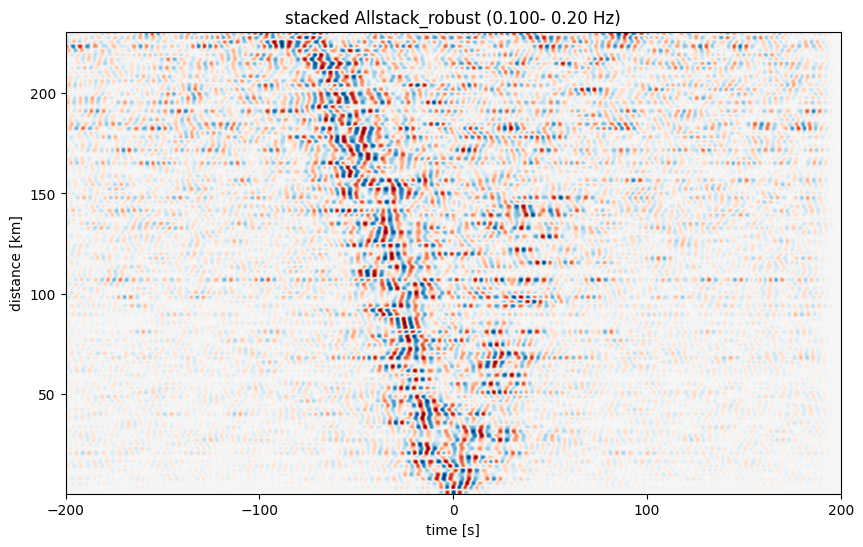

In [18]:
plot_all_moveout(sta_stacks, 'Allstack_robust', 0.1, 0.2, 'ZZ', 1)